In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# adjacency matrix from file .dat

In [ ]:

def dat_to_adjacency_matrix(file_path):
    # Read data from the .dat file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize an empty dictionary to store edges
    edges = {}

    # Process each line in the file
    for line in lines:
        # Split the line into two nodes
        node1, node2 = map(int, line.strip().split())

        # Add the nodes to the dictionary
        if node1 in edges:
            edges[node1].append(node2)
        else:
            edges[node1] = [node2]

    # Determine the number of nodes in the network
    num_nodes = max(edges.keys())

    # Initialize an empty adjacency matrix
    adj_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    # Fill the adjacency matrix based on the edges
    for node1 in edges:
        for node2 in edges[node1]:
            adj_matrix[node1 - 1][node2 - 1] = 1  # Subtract 1 to adjust for 0-based indexing

    return np.array(adj_matrix)


# k rank functions

## signal propagation

In [ ]:

import numpy as np

def signal_propagation(adjacency_matrix,  Nmax):
    """
    Signal propagation to compute vertex similarities.
    """
    n = adjacency_matrix.shape[0]
    I = np.eye(n)
    #α est un paramètre qui contrôle l'influence de la matrice d'adjacence par rapport à l'identité.
    U = np.linalg.matrix_power(I + adjacency_matrix, Nmax)
    return U


## page rank

In [ ]:
import numpy as np

def pagerank(adjacency_matrix, alpha=0.6, max_iterations=100, tolerance=1e-10):
    # Calculate out-degree for each node
    out_degree = np.sum(adjacency_matrix, axis=1)

     # Check for zero out-degrees
    zero_out_degree_indices = np.where(out_degree == 0)[0]
    if len(zero_out_degree_indices) > 0:
        # Handle nodes with zero out-degree by setting their out-degree to 1
        out_degree[zero_out_degree_indices] = 1

    # Total number of nodes
    n = adjacency_matrix.shape[0]

    # Initialize PageRank vector
    r = np.ones(n) / n

    # Initialize teleportation vector
    v = np.ones(n) / n

    # Power iteration to compute PageRank
    for _ in range(max_iterations):
        r_new = alpha * np.dot(r, adjacency_matrix / out_degree[:, np.newaxis]) + (1 - alpha) * v
        if np.linalg.norm(r_new - r, ord=1) < tolerance:
            break
        r = r_new

    return r



## Calculate similarity


In [ ]:

import numpy as np

def calculate_negative_euclidean_distances(adjacency_matrix):
    # Calculate Euclidean distances
    distances = np.sqrt(np.sum((adjacency_matrix[:, np.newaxis] - adjacency_matrix) ** 2, axis=2))

    # Return negative distances
    return -distances


## Find initial seeds


In [ ]:
import numpy as np

def find_initial_seeds(adjacency_matrix, K, threshold=0.5, tolerance=1e-6):
    # Calculate PageRank scores
    pagerank_scores = pagerank(adjacency_matrix)
    # Calculate negative Euclidean distances
    euclidean_distances = calculate_negative_euclidean_distances(adjacency_matrix)

    # Initialize list to store selected seeds
    seeds = []

    # Find initial seeds
    for _ in range(K):
        # Find vertex with maximum PageRank score
        max_pagerank_index = np.argmax(pagerank_scores)

        # Check similarity with existing seeds
        similarity = euclidean_distances[max_pagerank_index, seeds]

        # If similarity with all existing seeds is below threshold, add as seed
        if np.all(similarity < threshold):
            seeds.append(max_pagerank_index)

        # Set PageRank score to -inf to prevent re-selection
        pagerank_scores[max_pagerank_index] = -np.inf

    return seeds


## Affecter les nœuds au clusters

In [ ]:
import numpy as np

def assign_nodes_to_clusters(U, seeds):
    """
    Assign nodes to clusters based on signal propagation matrix U and seed vertices.
    """
    num_nodes = U.shape[0]
    num_seeds = len(seeds)
    # Initialize cluster assignments
    clusters = np.zeros(num_nodes, dtype=int)
    for i in range(num_nodes):
        # Find the seed with the maximum influence (signal) on the node
        max_influence_seed = np.argmax(U[i, seeds])

        # Assign the node to the cluster of the seed with maximum influence
        clusters[i] = max_influence_seed
    return clusters


## Mise à jour des seeds aprés l'affectation

In [ ]:

def update_seeds(clusters, adjacency_matrix):
    """
    Update seeds based on rank centrality and vertex similarities.
    """
    updated_seeds = []
    num_clusters = np.max(clusters) + 1
    for cluster_id in range(num_clusters):
        # Get the nodes belonging to the current cluster
        cluster_nodes = np.where(clusters == cluster_id)[0]
        if len(cluster_nodes) == 0:
            continue  # Skip empty clusters
        # Calculate PageRank scores for nodes within the cluster
        cluster_adjacency_matrix = adjacency_matrix[np.ix_(cluster_nodes, cluster_nodes)]
        pagerank_scores = pagerank(cluster_adjacency_matrix)
        # Select the node with the highest PageRank score as the new seed
        new_seed_index = np.argmax(pagerank_scores)
        new_seed = cluster_nodes[new_seed_index]
        updated_seeds.append(new_seed)
    return updated_seeds




# K_rank fonction

In [ ]:

def k_rank(adjacency_matrix, K, threshold,Nmax, max_iterations=100):
    """
    Perform K-rank algorithm to detect communities in the network.
    """
    row_sums = np.sum(adjacency_matrix, axis=1)
    zero_sum_mask = row_sums == 0
    row_sums[zero_sum_mask] = 1
    adjacency = adjacency_matrix / row_sums[:, np.newaxis]
    # Step 1: Signal propagation
    U = signal_propagation(adjacency, Nmax)
    seeds = find_initial_seeds( U, K, threshold)

    distance=calculate_negative_euclidean_distances(U)
    for _ in range(max_iterations):
        # Step 3: Cluster vertices into K communities
        clusters = assign_nodes_to_clusters(distance, seeds)
        # Step 4: Update seeds based on rank centrality
        updated_seeds = update_seeds(clusters, U)

        if seeds == updated_seeds:
            break
        else:
            seeds = updated_seeds

    return clusters, seeds



# gml to adjacency matrix

In [ ]:
import networkx as nx
import numpy as np

def read_gml_to_adjacency_matrix(file_path):
    # Read the GML file into a NetworkX graph
    G = nx.read_gml(file_path, label='id')

    # Convert the graph to an adjacency matrix
    adjacency_matrix = nx.convert_matrix.to_numpy_array(G)

    return adjacency_matrix



# read groundtruth from txt file

In [ ]:

def read_labels_from_file(file_path):
    """
    Read the labels from a text file.
    """
    with open(file_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return labels

# read groundtruth from dat file

In [ ]:
def read_labels_from_file_dat(file_path):
    """
    Read the labels from a .dat file.
    """
    labels = np.loadtxt(file_path, delimiter='\t', dtype=int)
    return labels[:, 1].astype(int)  # Assuming the labels are in the first column


# accuracy

In [ ]:

def compute_accuracy(ground_truth_labels, predicted_clusters):
    """
    Compute accuracy by comparing ground truth labels with predicted clusters.
    """
    # Compute accuracy
    n = len(ground_truth_labels)
    correct = sum(1 for i in range(n) if ground_truth_labels[i] == predicted_clusters[i])
    accuracy = correct / n
    return accuracy





In [ ]:
from sklearn.metrics import accuracy_score

def relabel_communities(true_communities, predicted_communities):
    # Create a dictionary to store the mapping from predicted labels to true labels
    label_mapping = {}

    # Iterate over unique labels in predicted communities
    for pred_label in set(predicted_communities):
        # Find the true label that maximizes overlap with the predicted label
        overlap = [sum(1 for true, pred in zip(true_communities, predicted_communities) if true == true_label and pred == pred_label) for true_label in set(true_communities)]
        best_true_label = max(set(true_communities), key=lambda x: overlap[x])

        # Map the predicted label to the true label
        label_mapping[pred_label] = best_true_label

    # Relabel predicted communities using the mapping
    relabeled_predicted_communities = [label_mapping[label] for label in predicted_communities]

    return relabeled_predicted_communities

def evaluate_accuracy(true_communities, predicted_communities):
    # Calculate accuracy
    acc = accuracy_score(true_communities, predicted_communities)

    return acc


# nmi

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score

def compute_nmi(ground_truth_labels, predicted_clusters):
    """
    Compute NMI (Normalized Mutual Information) between ground truth labels and predicted clusters.
    """
    nmi = normalized_mutual_info_score(ground_truth_labels, predicted_clusters)
    return nmi




# modularity


In [ ]:
def calculate_modularity(adj_matrix, communities):
    num_nodes = len(adj_matrix)
    num_edges = np.sum(adj_matrix) / 2  # For undirected graphs, divide by 2 to avoid double counting

    modularity = 0.0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                modularity += (adj_matrix[i][j] - (np.sum(adj_matrix[i]) * np.sum(adj_matrix[j]) / (2 * num_edges))) \
                              * (communities[i] == communities[j])  # Kronecker delta

    modularity /= (2 * num_edges)  # Normalize by the total sum of edge weights
    return modularity

# plot graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_graph_with_communities(adjacency_matrix, communities, title):
    # Create an empty graph
    G = nx.Graph()

    # Add edges based on the adjacency matrix
    for i in range(len(adjacency_matrix)):
        for j in range(len(adjacency_matrix)):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)

    # Set node positions using spring layout, but store them based on community
    pos = {}
    for node, community in zip(G.nodes(), communities):
        if community not in pos:
            pos[community] = {}
        if node not in pos[community]:
            pos[community][node] = nx.spring_layout(G, center=[community, community])[node]

    # Draw nodes with different colors for each community
    for community, nodes in pos.items():
        nx.draw_networkx_nodes(G, nodes, node_color=community, cmap=plt.get_cmap('viridis'), node_size=50, label=f'Community {community}')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Add title and legend
    plt.title(title)
    plt.legend()

    # Show plot
    plt.show()



In [ ]:
def relabel_communities(true_communities, predicted_communities):
    label_mapping = {}
    for pred_label in set(predicted_communities):
        # Find the true label that maximizes overlap with the predicted label
        overlap = [sum(1 for true, pred in zip(true_communities, predicted_communities) if true == true_label and pred == pred_label) for true_label in set(true_communities)]

        # Find the index of the maximum overlap
        best_true_label_index = overlap.index(max(overlap))

        # Map the predicted label to the true label
        label_mapping[pred_label] = list(set(true_communities))[best_true_label_index]

    # Relabel predicted communities
    relabeled_predicted_communities = [label_mapping[pred_label] for pred_label in predicted_communities]

    return relabeled_predicted_communities


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def matrice_adjacente_vers_graphe(matrice_adjacente):
    # Création d'un graphe non dirigé
    G = nx.Graph()

    # Ajout des arêtes au graphe en fonction de la matrice d'adjacence
    for i in range(len(matrice_adjacente)):
        for j in range(len(matrice_adjacente[i])):
            if matrice_adjacente[i][j] == 1:
                G.add_edge(i, j)

    return G

In [ ]:
def vector_to_community_list(community_vector):
    community_dict = {}
    for node, community in enumerate(community_vector):
        if community not in community_dict:
            community_dict[community] = [node]
        else:
            community_dict[community].append(node)
    community_list = list(community_dict.values())
    return community_list

# Example usage:
community_vector = [0, 1, 0, 1, 2, 2, 0, 2, 1, 1]  # Example community vector
community_list = vector_to_community_list(community_vector)
print(community_list)


[[0, 2, 6], [1, 3, 8, 9], [4, 5, 7]]


# F statistic for best k :

In [ ]:
import numpy as np
def f_statistic(u_matrix, clusters_v,k):
    unique_clusters = set(clusters_v)
    clusters = [set() for _ in range(max(unique_clusters) + 1)]

    for i, cluster in enumerate(clusters_v):
        clusters[cluster].add(i)
    sum1 = 0
    sum2 = 0
    n =  u_matrix.shape[0]
    u =  np.sum(u_matrix, axis=0)/n
    for community in clusters:
        somme = 0
        for node in community:
            somme = somme + u_matrix[node, :]
        ui = somme / len(community)
        sum1 = sum1 + (np.linalg.norm(ui - u)**2)* len(community)
        interm =0
        for node in community :
            interm = interm + (np.linalg.norm(u_matrix[node, :] - ui)**2)
        sum2 = sum2 + (interm / (n -k))
    sum1 = sum1/(k-1)
    return sum1/sum2


In [ ]:
import numpy as np

def find_best_k(adjacency_matrix, max_k,mu,c):
    best_k = 0
    best_f_statistic = 0
    k = 2
    while  k< max_k+1 :
        clusters,seeds = k_rank(adjacency_matrix,k,mu,c)
        u= signal_propagation(adjacency_matrix,c)
        current_f =f_statistic(u, clusters , k)
        if current_f > best_f_statistic:
            best_k = k
            best_f_statistic = current_f
        k = k+1

    return best_k, best_f_statistic


# tests

# karate

In [ ]:
adj_matrix_karate = read_gml_to_adjacency_matrix(r"DataSets/réels/karate/karate.gml")


In [ ]:
clusters,seeds = k_rank(adj_matrix_karate,2,-0.2,5,50)


In [ ]:
ground_truth_file = r"DataSets/réels/karate/groundTruth.txt"

ground_truth_labels = read_labels_from_file(ground_truth_file)
predicted_clusters = clusters
mapping = {0: 1, 1: 0}
predicted_clusters = np.array([mapping[val] for val in predicted_clusters])
accuracy = compute_accuracy(ground_truth_labels, predicted_clusters)
nmi = compute_nmi(ground_truth_labels, predicted_clusters)
bestk , f =  find_best_k(adj_matrix_karate, 10,-0.2,5)
print("best k:", bestk)
print("the f statistic of the best k:",f)
modularity=calculate_modularity(adj_matrix_karate,clusters)
print("Modularity: ", modularity)
print("Accuracy:", accuracy)
print("NMI:", nmi)

best k: 2
the f statistic of the best k: 6.394290986836885
Modularity:  0.42126890203813094
Accuracy: 1.0
NMI: 1.0


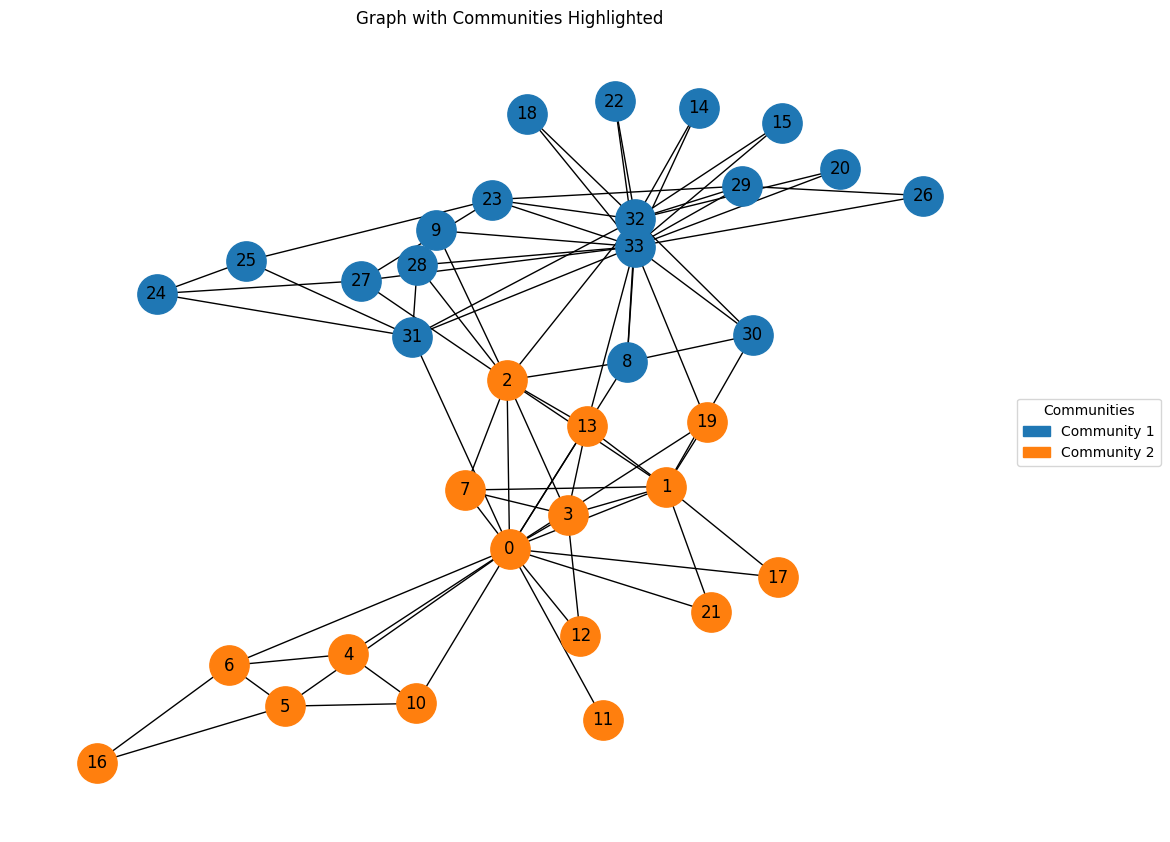

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming clusters is a vector where clusters[i] represents the community of node i

# Convert adjacency matrix to graph
graphe = matrice_adjacente_vers_graphe(adj_matrix_karate)

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graphe)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graphe, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
num_communities = len(np.unique(clusters))
for i in range(num_communities):
    color = f'C{i}'  # Assign a unique color to each community
    nodes_in_community = np.where(clusters == i)[0]
    nx.draw_networkx_nodes(graphe, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
    legend_labels.append(f'Community {i+1}')
    legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


# dauphins

In [ ]:
adj_matrix_dau = read_gml_to_adjacency_matrix(r"DataSets/réels/dolphins/dolphins.gml")
clusters,seeds = k_rank(adj_matrix_dau,2,-0.8,60)

ground_truth_file = r"DataSets/réels/dolphins/groundTruth.txt"

ground_truth_labels = read_labels_from_file(ground_truth_file)
predicted_clusters = clusters

accuracy = compute_accuracy(ground_truth_labels, predicted_clusters)
nmi = compute_nmi(ground_truth_labels, predicted_clusters)
bestk , f =  find_best_k(adj_matrix_dau, 10,-0.8,60)
print("best k:", bestk)
print("the f statistic of the best k:",f)
modularity=calculate_modularity(adj_matrix_dau,clusters)
print("Modularity: ", modularity)
print("Accuracy:", accuracy)
print("NMI:", nmi)

best k: 2
the f statistic of the best k: 37.41026108955108
Modularity:  0.40010284403306645
Accuracy: 0.9838709677419355
NMI: 0.8888359488640809


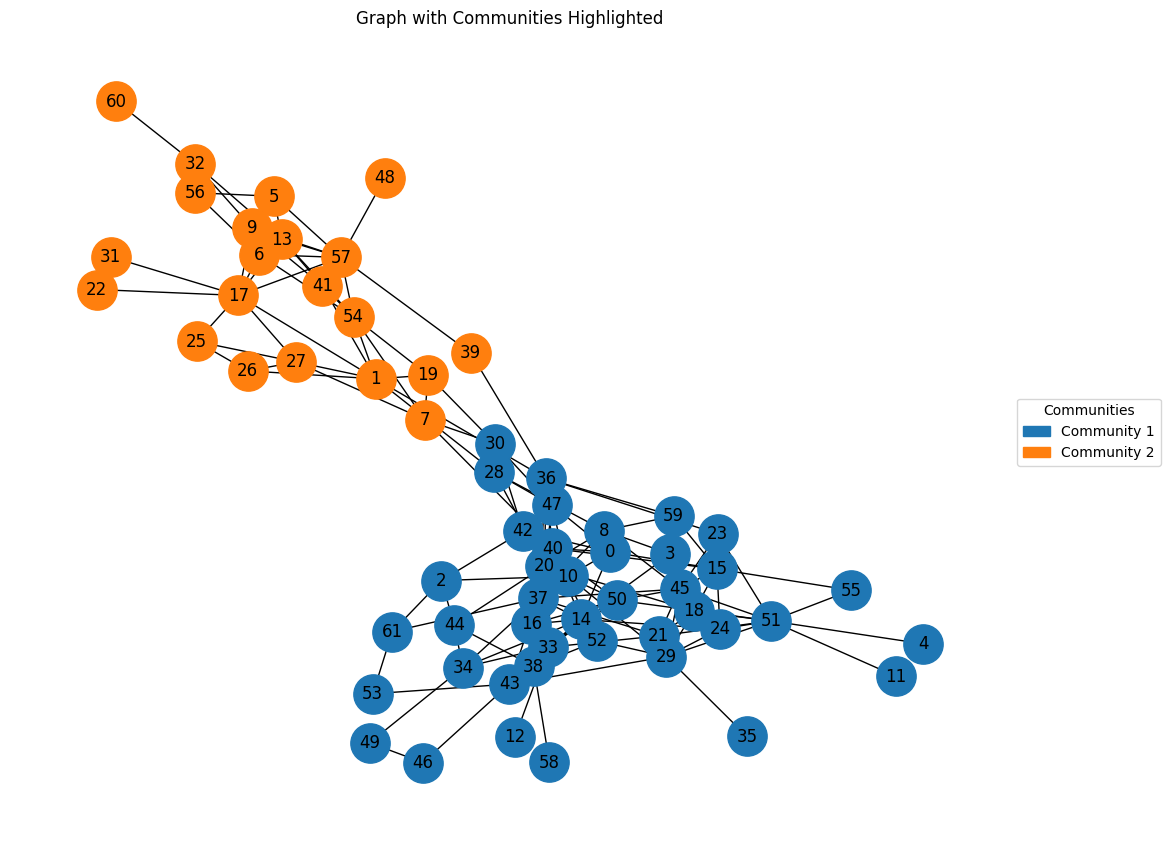

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming clusters is a vector where clusters[i] represents the community of node i

# Convert adjacency matrix to graph
graphe = matrice_adjacente_vers_graphe(adj_matrix_dau)

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graphe)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graphe, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
num_communities = len(np.unique(clusters))
for i in range(num_communities):
    color = f'C{i}'  # Assign a unique color to each community
    nodes_in_community = np.where(clusters == i)[0]
    nx.draw_networkx_nodes(graphe, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
    legend_labels.append(f'Community {i+1}')
    legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


# football

In [ ]:
adj_matrix_foot = read_gml_to_adjacency_matrix(r"DataSets/réels/football/football.gml")
clusters,seeds = k_rank(adj_matrix_foot,12,-0.8,6)

ground_truth_file = r"DataSets/réels/football/groundTruth.txt"

ground_truth_labels = read_labels_from_file(ground_truth_file)

predicted_clusters = clusters

series1 = predicted_clusters

series2 = ground_truth_labels

# Créer un dictionnaire pour mapper les valeurs de la série1 à la série2
mapping = dict(zip(series1, series2))
# Mapper les valeurs de la série1 à la série2
mapped_series = [mapping[value] for value in series1]

accuracy = compute_accuracy(ground_truth_labels, mapped_series)

nmi = compute_nmi(ground_truth_labels, mapped_series)
bestk , f =  find_best_k(adj_matrix_foot, 20,-0.8,7)
print("best k:", bestk)
print("the f statistic of the best k:",f)
modularity=calculate_modularity(adj_matrix_foot,clusters)
print("Modularity: ", modularity)
print("Accuracy:", accuracy)
print("NMI:", nmi)

best k: 14
the f statistic of the best k: 73.28734477900682
Modularity:  0.524286197105131
Accuracy: 0.7652173913043478
NMI: 0.850715602716019


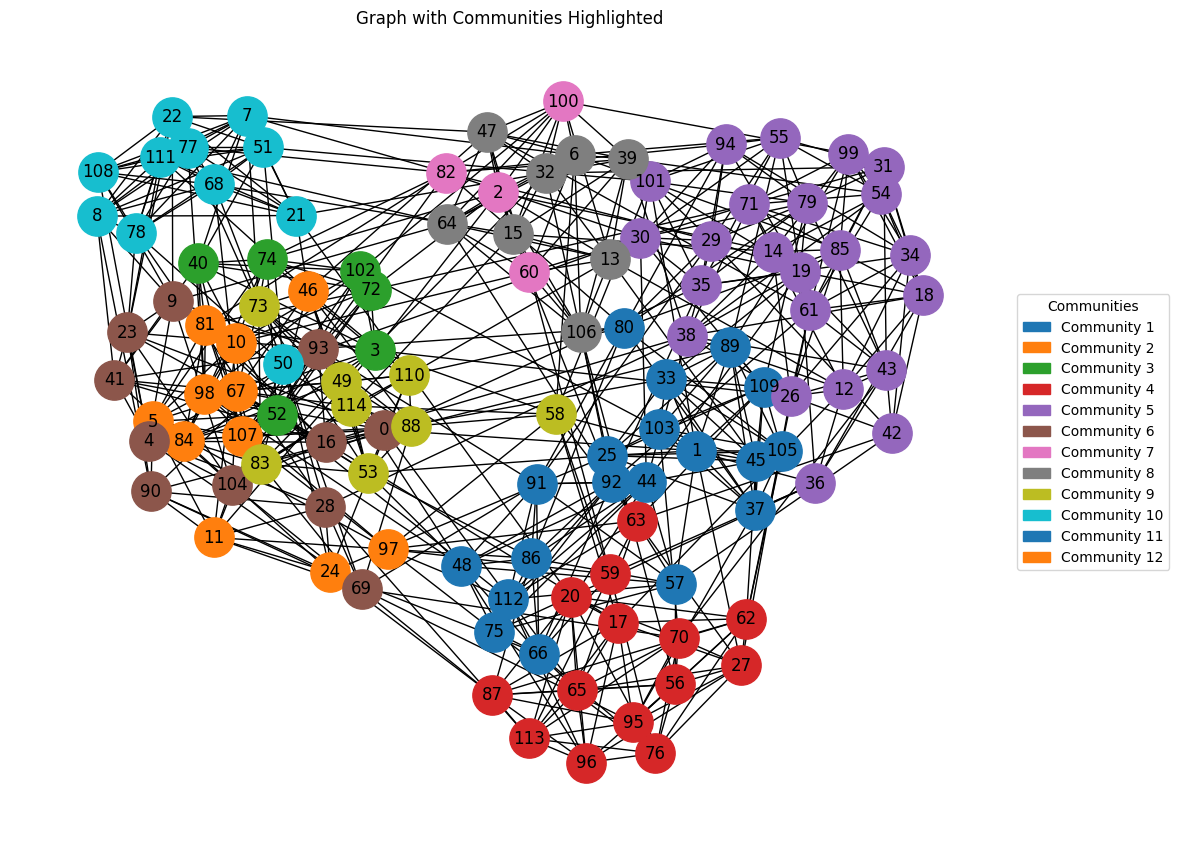

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming clusters is a vector where clusters[i] represents the community of node i

# Convert adjacency matrix to graph
graphe = matrice_adjacente_vers_graphe(adj_matrix_foot)

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graphe)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graphe, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
num_communities = len(np.unique(clusters))
for i in range(num_communities):
    color = f'C{i}'  # Assign a unique color to each community
    nodes_in_community = np.where(clusters == i)[0]
    nx.draw_networkx_nodes(graphe, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
    legend_labels.append(f'Community {i+1}')
    legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


# 0.15

In [ ]:
file_path = '0.15/network.dat'
adj_matrix = dat_to_adjacency_matrix(file_path)
print(adj_matrix)
print(adj_matrix.shape)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(128, 128)


In [ ]:
clusters,seeds = k_rank(adj_matrix,4,0.7,100)
print("clusters",clusters)
print(seeds)

clusters [0 3 2 3 2 1 0 0 0 2 1 3 3 3 3 1 0 0 2 1 0 0 3 3 2 2 0 3 2 2 3 1 0 1 0 2 3
 3 2 0 2 2 3 2 1 0 0 3 1 0 0 0 0 3 1 1 1 1 1 1 3 1 0 1 0 1 1 3 1 2 3 0 3 0
 1 0 1 2 1 2 3 3 3 0 2 2 3 0 2 2 2 2 3 2 3 3 0 1 0 2 1 1 1 2 3 3 1 2 2 0 0
 1 1 2 0 2 2 0 1 3 3 2 3 2 1 3 1 0]
[71, 118, 25, 42]


In [ ]:
ground_truth_file = "0.15/community.dat"

# Assuming the function read_labels_from_file_dat reads the ground truth labels from a file
ground_truth_labels = read_labels_from_file_dat(ground_truth_file)

# Assuming 'clusters' contains the predicted clusters
predicted_clusters = clusters

mapping = {0: 3, 1: 1,2:2,3:4}
predicted_clusters = np.array([mapping[val] for val in predicted_clusters])

accuracy = compute_accuracy(ground_truth_labels, predicted_clusters)
nmi = compute_nmi(ground_truth_labels, predicted_clusters)
bestk , f =  find_best_k(adj_matrix, 20,0.7,100)
print("best k:", bestk)
print("the f statistic of the best k:",f)
modularity=calculate_modularity(adj_matrix,clusters)
print("Modularity: ", modularity)
print("Accuracy:", accuracy)
print("NMI:", nmi)


best k: 4
the f statistic of the best k: 2465.690139320459
Modularity:  0.609375
Accuracy: 1.0
NMI: 1.0


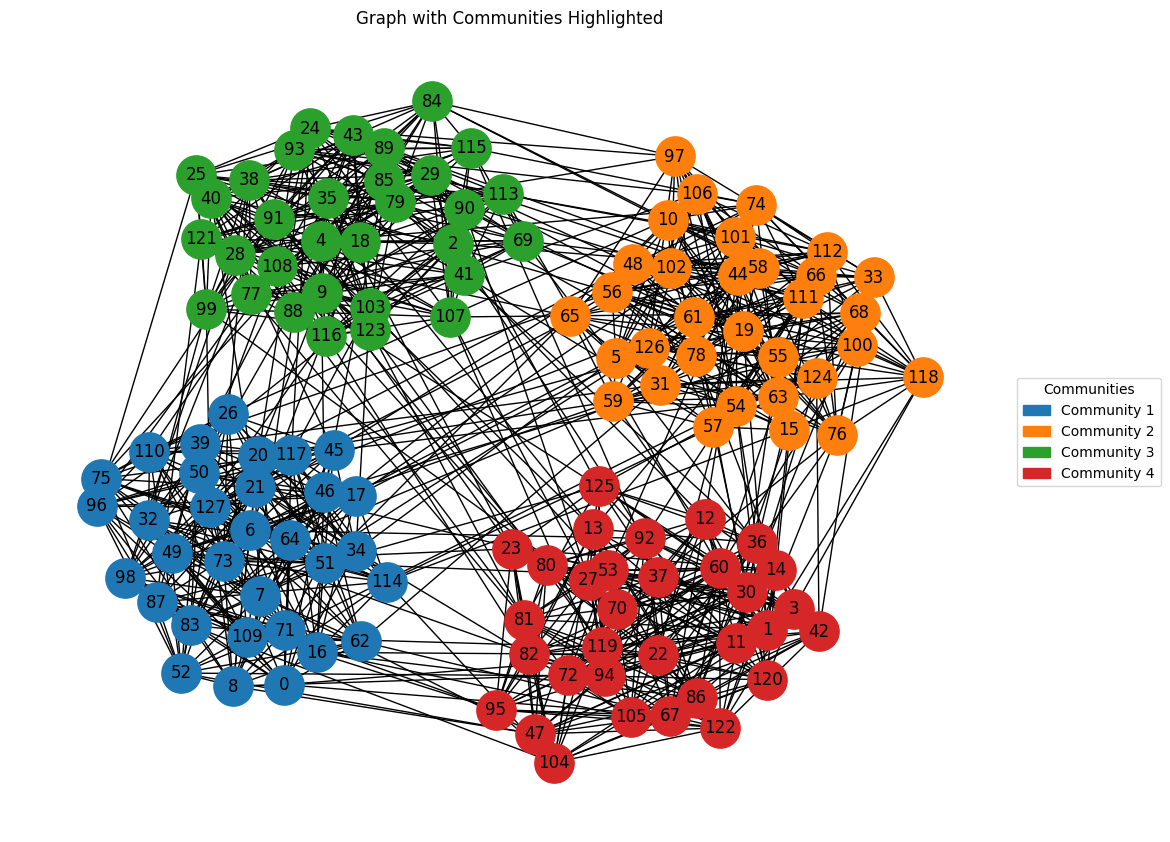

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming clusters is a vector where clusters[i] represents the community of node i

# Convert adjacency matrix to graph
graphe = matrice_adjacente_vers_graphe(adj_matrix)

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graphe)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graphe, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
num_communities = len(np.unique(clusters))
for i in range(num_communities):
    color = f'C{i}'  # Assign a unique color to each community
    nodes_in_community = np.where(clusters == i)[0]
    nx.draw_networkx_nodes(graphe, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
    legend_labels.append(f'Community {i+1}')
    legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


# 0.40

In [ ]:
file_path = '0.40/network.dat'
adj_matrix = dat_to_adjacency_matrix(file_path)


clusters,seeds = k_rank(adj_matrix,4,0.6,40,20)


ground_truth_file = "0.40/community.dat"

ground_truth_labels = read_labels_from_file_dat(ground_truth_file)


predicted_clusters = clusters

series1 = predicted_clusters

series2 = ground_truth_labels

# Créer un dictionnaire pour mapper les valeurs de la série1 à la série2
mapping = dict(zip(series1, series2))
# Mapper les valeurs de la série1 à la série2
mapped_series = [mapping[value] for value in series1]

accuracy = compute_accuracy(ground_truth_labels, mapped_series)

nmi = compute_nmi(ground_truth_labels, mapped_series)


bestk , f =  find_best_k(adj_matrix, 20,0.6,100)
print("best k:", bestk)
print("the f statistic of the best k:",f)


modularity=calculate_modularity(adj_matrix,predicted_clusters)
print("Modularity: ", modularity)
print("Accuracy:", accuracy)
print("NMI:", nmi)


best k: 16
the f statistic of the best k: 42.86078557630393
Modularity:  0.2967529296875
Accuracy: 0.75
NMI: 0.8310041089392561


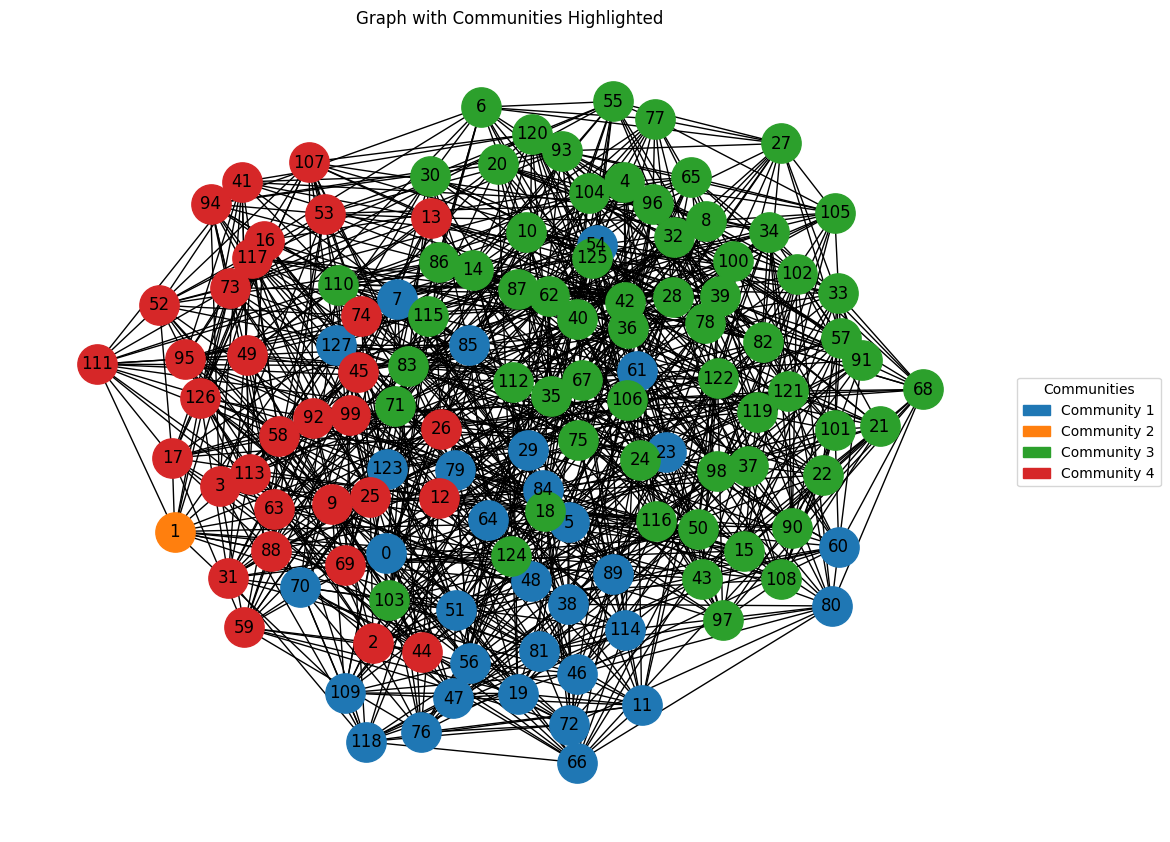

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming clusters is a vector where clusters[i] represents the community of node i

# Convert adjacency matrix to graph
graphe = matrice_adjacente_vers_graphe(adj_matrix)

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graphe)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graphe, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
num_communities = len(np.unique(clusters))
for i in range(num_communities):
    color = f'C{i}'  # Assign a unique color to each community
    nodes_in_community = np.where(clusters == i)[0]
    nx.draw_networkx_nodes(graphe, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
    legend_labels.append(f'Community {i+1}')
    legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()
